In [11]:
import numpy as np
np.set_printoptions(threshold='nan')
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# read data
data1 = pd.read_csv("set1.csv", parse_dates=True, index_col='DATETIME')
data2 = pd.read_csv("set2.csv", parse_dates=True, index_col='DATETIME')

# save labels
target = data2[" ATT_FLAG"]

# remove flag as you should not do pca on this column
del data1["ATT_FLAG"]
del data2[" ATT_FLAG"]

# normalize data to have zero mean and unit variance
# pca does not work well with non-normalized data
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
train = scaler.fit_transform(data1)
test = scaler.fit_transform(data2)

# check if data is indeed scaled by looking at mean and std here
for i in range(43):
    print "train mean/ std: ", np.mean(train[:, i]), np.std(train[:, i])
    print "test mean/ std: ", np.mean(test[:, i]), np.std(test[:, i])

train mean/ std:  -2.4168671984534854e-16 1.0
test mean/ std:  -1.6372932323895054e-16 1.0
train mean/ std:  -1.0016211376141123e-16 1.0
test mean/ std:  1.1567370369089493e-16 1.0
train mean/ std:  -2.0726866557207008e-16 1.0
test mean/ std:  2.6962179463245363e-16 0.9999999999999999
train mean/ std:  -1.8978084712688442e-16 0.9999999999999999
test mean/ std:  -6.532162090779949e-16 1.0
train mean/ std:  -1.3311017749871756e-16 0.9999999999999999
test mean/ std:  -5.626334925847573e-16 1.0
train mean/ std:  3.1046200119731347e-15 0.9999999999999999
test mean/ std:  1.4807935156312358e-15 1.0000000000000002
train mean/ std:  -2.8386024142910064e-17 0.9999999999999999
test mean/ std:  3.878471241400595e-16 1.0
train mean/ std:  3.7712860647009084e-16 1.0
test mean/ std:  -6.634227123448386e-16 1.0
train mean/ std:  0.0 0.0
test mean/ std:  0.0 0.0
train mean/ std:  -2.751416768709211e-16 0.9999999999999999
test mean/ std:  2.4665716228205535e-16 1.0
train mean/ std:  4.115973500721959e-

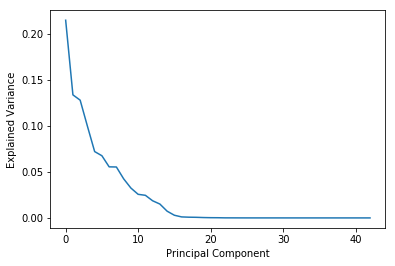

In [12]:
# start calculating principle components
pcs = decomposition.PCA()
pcs.fit(train)
model = pcs.transform(train)

# plot variance captured per principal component
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.plot(pcs.explained_variance_ratio_)

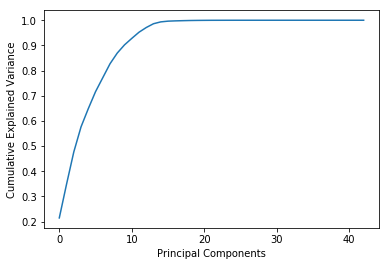

In [13]:
# plot cumulative variance captured of principle components
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pcs.explained_variance_ratio_.cumsum())

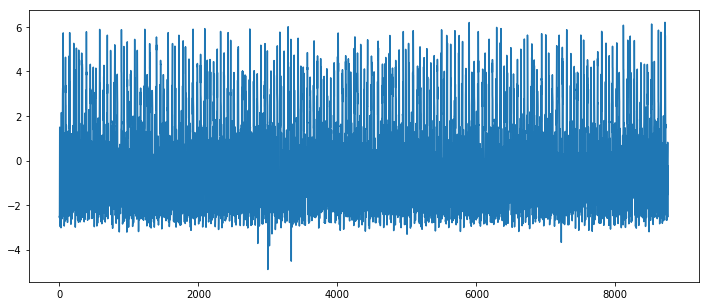

In [24]:
# we now use the method from Lakhina et al. (see report) to check which pcs should model the normal/anomalous subspace
# we use the first 11 components for our normal subspace
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(model[:,1])

True positives:  29
False positives:  15
False Negatives:  190
True Negatives:  3943


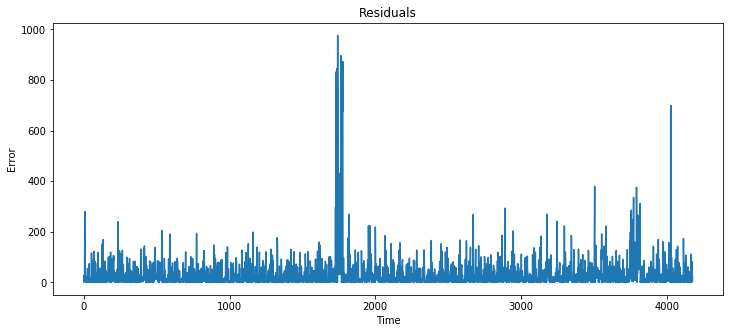

In [25]:
cols = pcs.components_

# we used the method described by Lakhina et al.
# P is the m times r matrix with r the number of normal axes and m the dimension
# C is just the matrix P times the transpose of P
# I is the identity matrix 
P = np.transpose(cols[0:11])
P_transpose = np.transpose(P)
C = np.dot(P, P_transpose)
I = np.identity(43)
errors = np.zeros((test.shape[0]))
prediction = np.zeros((test.shape[0]))

# project set 2 (test data) on anomalous subspace as described by Lakina et al.
residuals = np.zeros((test.shape))
for i in range(test.shape[0]):
    y = np.transpose(test[i])
    residuals[i] = np.dot(I - C, y)  

# threshold is 250 as this gives smaller FP rate
# if the error is bigger than threshold -> anomaly
# we use the squared prediction error (again as described by Lakhina et al.)
threshold = 250
for i in range(test.shape[0]):
    errors[i] = np.square(np.sum(np.subtract(residuals[i], test[i])))     
    if(errors[i] > threshold):
        prediction[i] = 1
        
TP = 0
FP = 0
TN = 0
FN = 0
for i in range(test.shape[0]):
    if(target[i] == 1 and prediction[i] == 1):
        TP = TP + 1
    if(target[i] == 0 and prediction[i] == 1) or (target[i] == -999 and prediction[i] == 1):
        FP = FP + 1
    if(target[i] == 1 and prediction[i] == 0):
        FN = FN + 1    
    if(target[i] == 0 and prediction[i] == 1) or (target[i] == -999 and prediction[i] == 0):
        TN = TN + 1
print "True positives: ", TP
print "False positives: ", FP
print "False Negatives: ", FN
print "True Negatives: ", TN
        
plt.plot(errors)
plt.ylabel("Error")
plt.xlabel("Time")
plt.title("Residuals")
plt.savefig("residuals.png")

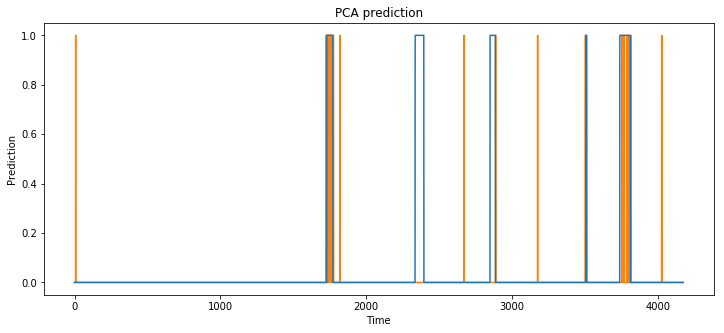

In [27]:
# creating plot to show the overlap of anomalies predicted and true anomalies
target_for_overlap = np.zeros(target.shape[0])
for i in range(target.shape[0]):
    if target[i] == -999 or target[i] == 0:
        target_for_overlap[i] = 0
    else:
        target_for_overlap[i] = 1
plt.plot(target_for_overlap, zorder = 2)
plt.plot(prediction, zorder = 1)
plt.title("PCA prediction")
plt.xlabel("Time")
plt.ylabel("Prediction")
plt.savefig("pca.png")